In [7]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import image_analysis as ia # module with most of the code

%matplotlib notebook

## Extract frames from video

This needs to be done only once for every video

In [2]:
path = './T-data/18-11/'
video_name = 'B-ol10-aq30-spf1.wmv'

ia.extract_frames(path, video_name)

## Get arrays from video

In [2]:
folder = './T-data/18-11/B-ol10-aq30-spf1'

color = 1 # green

arrays, mean_array = ia.get_arrays(folder,color)

arrays.shape

Image.fromarray(mean_array).show()

## Subtract the mean

In [3]:
arrays_sub = ia.subtract_mean(arrays,mean_array)

m = -145.0, M = 154.0
Subtracting the bias will generate some overflow
Rescale arrays to avoid overflow? [y/n] y


In [19]:
# see an example

idx = 0

Image.fromarray(arrays[idx]).show()
Image.fromarray(arrays_sub[idx]).show()

## Rotation and gaussian filter

In [6]:
# test on one image

rotation = 32
filter_size = 3

img = ia.preprocess(arrays_sub[idx], rotation=rotation, filter_size=filter_size)
img.show()

In [11]:
# apply to all images
imgs = []
for array_sub in tqdm(arrays_sub):
    imgs.append(ia.preprocess(array_sub, rotation=rotation, filter_size=filter_size))

imgs = np.array(imgs,dtype=Image.Image)
# calibration image
calibr_img = ia.preprocess(arrays[idx], rotation=rotation, filter_size=0) # keep the image sharp

calibr_img.show()

100%|██████████| 299/299 [00:10<00:00, 27.76it/s]


## Channel analyzer

### Calibrate

In [ ]:
c = ia.Channel_analyzer()

<IPython.core.display.Javascript object>


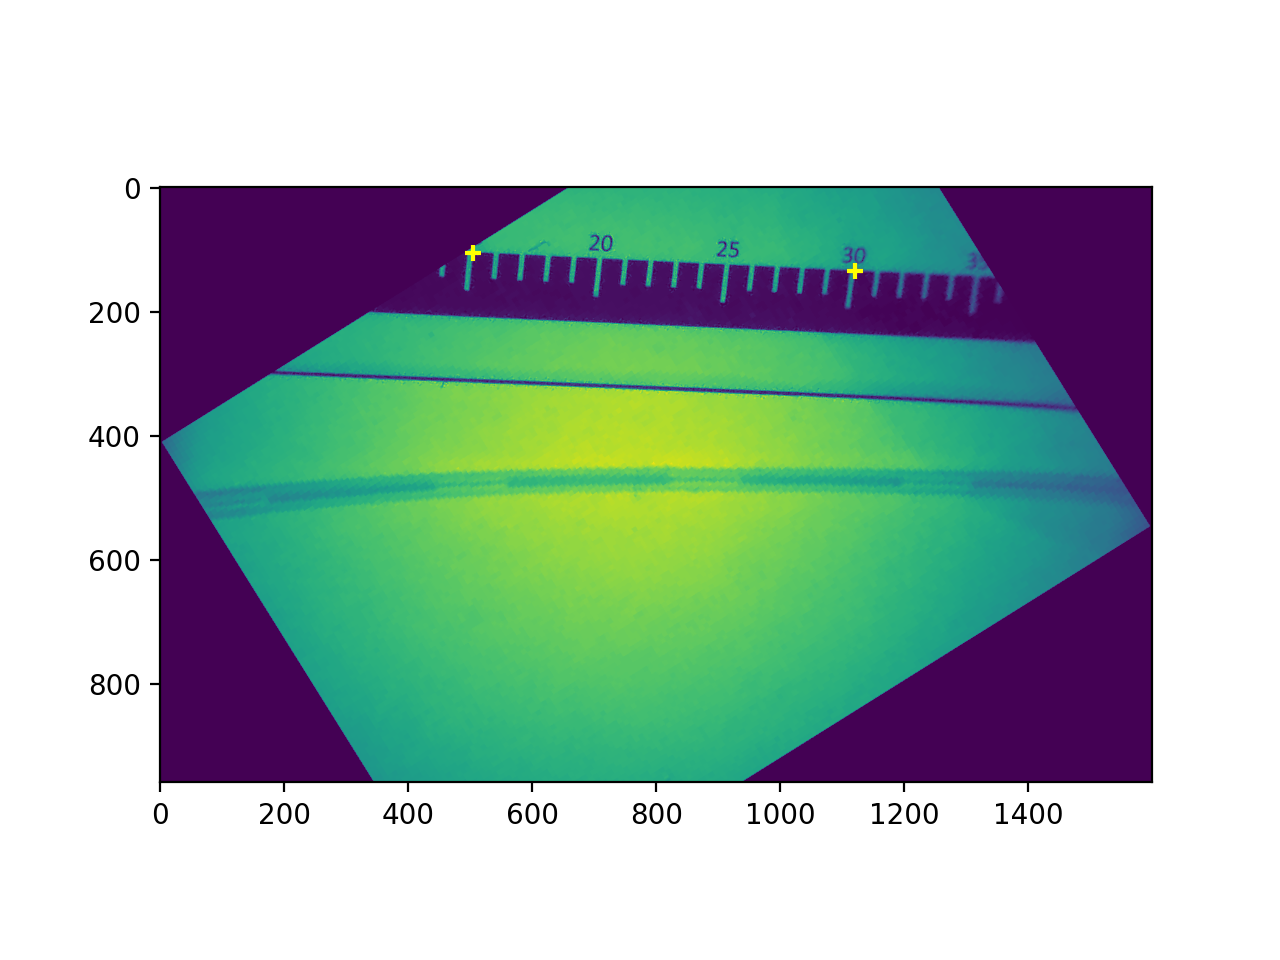

In [15]:
c.calibrate(calibr_img,15)

<IPython.core.display.Javascript object>


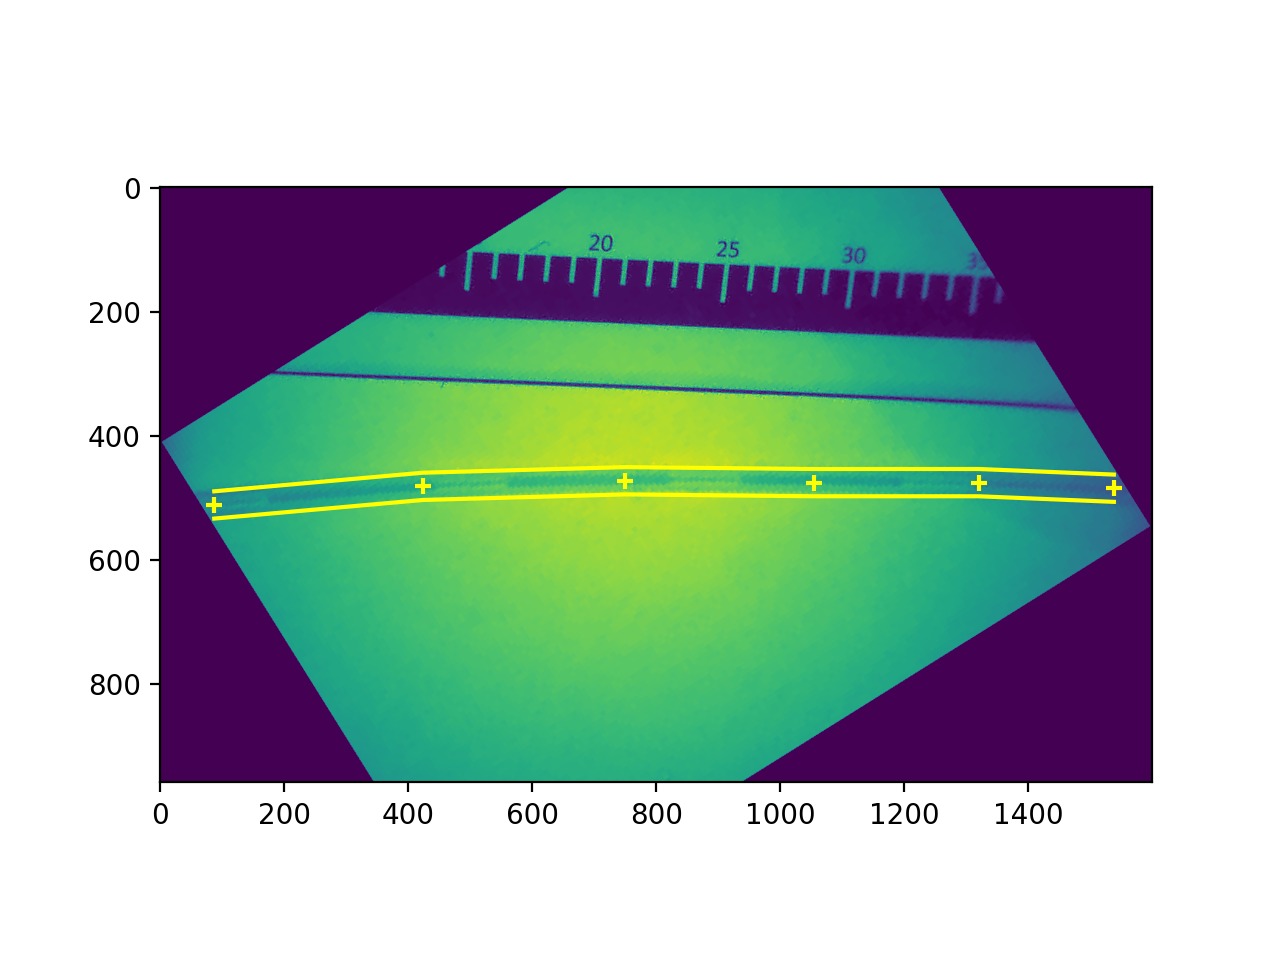

In [16]:
c.find_channel(calibr_img)

### Save calibration

In [17]:
c.save(name='calibr_B-ol10-aq30',folder='./T-data/18-11/')

### Load from existing calibration

In [ ]:
c.load(name='calibr_B-ol10-aq30',folder='./T-data/18-11')

### Try analysis on one image

<IPython.core.display.Javascript object>


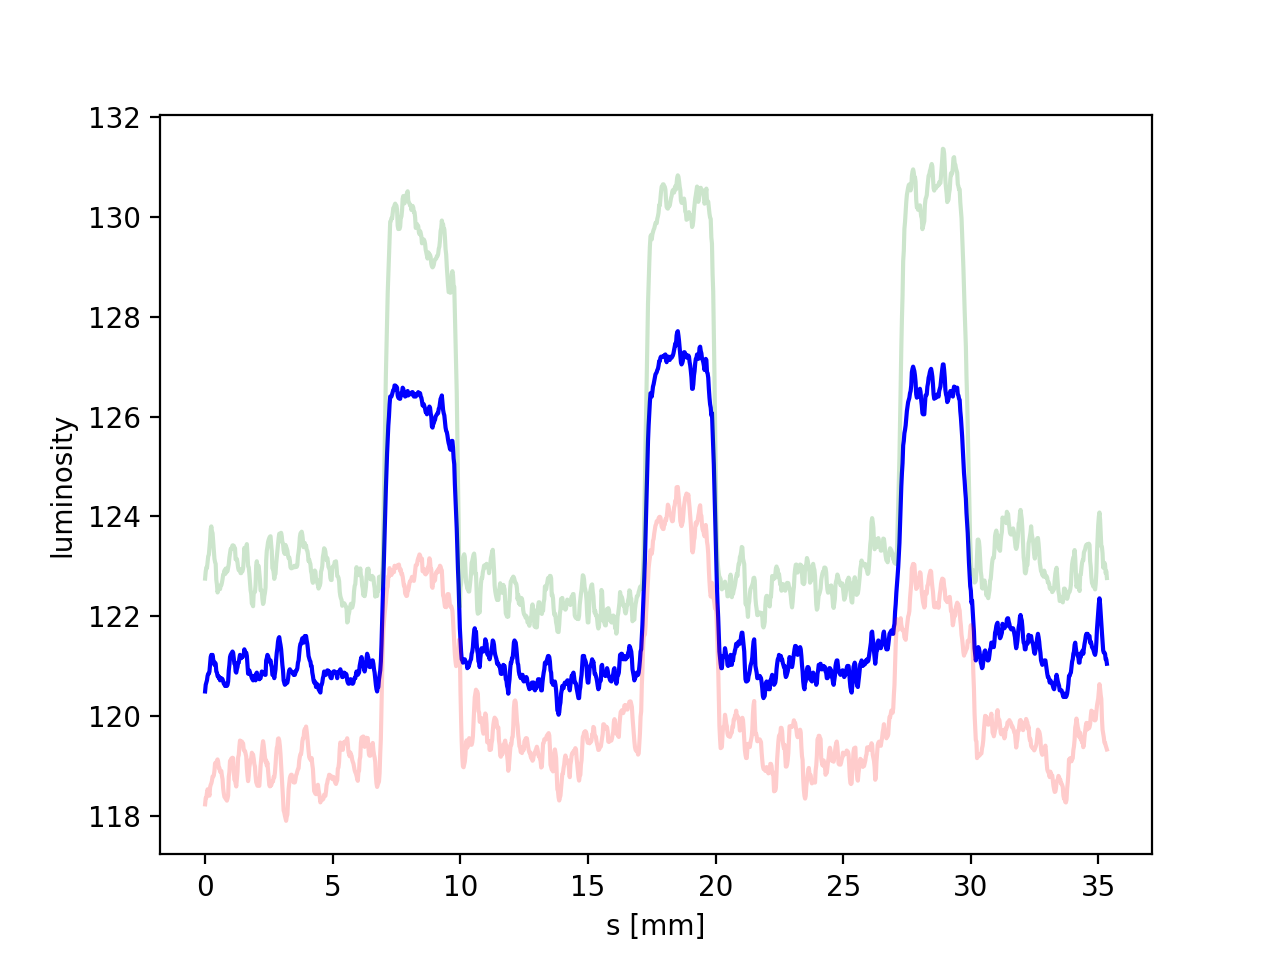

Text(0, 0.5, 'luminosity')

In [18]:
idx = 0

img = imgs[idx]
s, mean, std = c.evaluate(img)

plt.figure()
plt.plot(s,mean, color='blue')
plt.plot(s,mean - std,color='red',alpha=0.2)
plt.plot(s,mean + std,color='green',alpha=0.2)

plt.xlabel('s [mm]')
plt.ylabel('luminosity')

## Analyze the waveforms